### PIMA Dataset data analysis

This notebook analysis at the PIMA diabetes dataset and builds a model to predict the onset of diabetes in young Indiam woman

Thomas Binu tb6405, Chinmay Singh cks9089

### Imports

In [104]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import matplotlib.patches as mpatches
from IPython.display import HTML
from operator import itemgetter
import time


import pandas as pd
import numpy as np


# pd.options.mode.chained_assignment = None 

### Helper functions

In [105]:
def print_bold(text):
    display(Markdown("**{}**".format(text)))
    
def print_color(text, color='red'):
    display(HTML("<text style=color:{}>{}</text>".format(color, text)))


def display_confusion_matrix(target_test, target_predict):
    print_bold('Confusion Matrix')
    y_actu = pd.Series(target_test, name='Actual')
    y_pred = pd.Series(target_predict, name='Predicted')
    print(pd.crosstab(y_actu, y_pred))
    
# Basic graph plotting utility
def plot_roc_curve(confusion_matrix_list, models, x_label, y_label, model_names=''):
    
    tpr_fpr_list = []
    
    for idx, cm in enumerate(confusion_matrix_list):
    
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        print(models[idx][0], 'TPR:' + str(tpr), 'FPR:' + str(fpr))
    
        
        tpr_fpr_list.append((round(fpr, 2), round(tpr , 2)))
        
    tpr_fpr_list.sort(key=itemgetter(0))
    
    handles = []
    
    for model_name, model, color in models:
        patch = mpatches.Patch(color=color, label=model_name)
        handles.append(patch)
        
    fpr_list, tpr_list = zip(*tpr_fpr_list)
    
    fig, ax = plt.subplots()
    plt.plot(fpr_list, tpr_list, 'bs-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # ax.set_xlim([0,1])
    # ax.set_ylim([0,1])

    for idx, _   in enumerate(tpr_list):
        
        tpr = tpr_list[idx]
        fpr = fpr_list[idx]
        plt.plot([fpr], [tpr], marker='o',  markersize=10, color=models[idx][2])
    plt.legend(handles=handles)
    plt.show()

### Read dataset

In [106]:
DATASET_NAME = 'datasets/diabetes_pima.csv'
COLUMNS = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
df = pd.read_csv(DATASET_NAME)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Show statistics of the dataset

In [107]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [108]:
df_target = df['Outcome']

# Drop the target variable from dataframe
df.drop('Outcome' , inplace = True, axis =1)
df_attr = df
df_attr.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


### Preprocessing
Replacing missing values with mean of the columns

In [109]:
imputer = Imputer(missing_values=0, strategy='mean', axis=0)

columns_to_impute = ["Insulin", "Glucose", "BloodPressure", "SkinThickness", "BMI"]

for columns in columns_to_impute:
    df_attr[columns]=imputer.fit_transform(df[[columns]])
    
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.000000,6.000000,17.00
Glucose,768.0,121.686763,30.435949,44.000,99.75000,117.000000,140.250000,199.00
BloodPressure,768.0,72.405184,12.096346,24.000,64.00000,72.202592,80.000000,122.00
SkinThickness,768.0,29.153420,8.790942,7.000,25.00000,29.153420,32.000000,99.00
Insulin,768.0,155.548223,85.021108,14.000,121.50000,155.548223,155.548223,846.00
BMI,768.0,32.457464,6.875151,18.200,27.50000,32.400000,36.600000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.372500,0.626250,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.000000,41.000000,81.00


### Split attribues for training and testing

In [110]:
attr_train, attr_test, target_train, target_test = train_test_split(df_attr , df_target)

### Models
Fit various models and check results

In [111]:
models = [('Decision Tree', DecisionTreeClassifier(max_depth= 5), 'red'), 
          ('Logistic Regression', LogisticRegression(), 'green'), 
          ('Random Forest', RandomForestClassifier(), 'yellow'),
          ('Naive Bayes', GaussianNB(), 'magenta'),
          ('Neural Network', MLPClassifier(hidden_layer_sizes = 5,  max_iter= 800), 'blue')]

predicted_results = []
time_elapsed = []

for model_names, model, _ in models:
    
    start = time.time()
    
    model.fit(attr_train, target_train)
    target_predict = model.predict(attr_test)
    
    end = time.time()
    
    time_elapsed.append(end - start)
    predicted_results.append(target_predict)

### Results
Show the results of various models

In [112]:
fpr_list = []
tpr_list = []
confusion_matrix_list = []

for idx, (model_name, model, _) in enumerate(models):
    print_color(model_name)
    print_bold('Accuracy Score')
    print(accuracy_score(target_test.values, predicted_results[idx]), end='\n\n')
    
    print_bold('Time taken')
    print(round(time_elapsed[idx], 3) , 'ms')
    
    display_confusion_matrix(target_test.values, predicted_results[idx])
    cm = confusion_matrix(target_test, predicted_results[idx])
    confusion_matrix_list.append(cm)
    
    print_bold('Classification Report')
    print(classification_report(target_test, predicted_results[idx]))

**Accuracy Score**

0.734375



**Time taken**

0.003 ms


**Confusion Matrix**

Predicted    0   1
Actual            
0          101  35
1           16  40


**Classification Report**

             precision    recall  f1-score   support

          0       0.86      0.74      0.80       136
          1       0.53      0.71      0.61        56

avg / total       0.77      0.73      0.74       192



**Accuracy Score**

0.78125



**Time taken**

0.006 ms


**Confusion Matrix**

Predicted    0   1
Actual            
0          114  22
1           20  36


**Classification Report**

             precision    recall  f1-score   support

          0       0.85      0.84      0.84       136
          1       0.62      0.64      0.63        56

avg / total       0.78      0.78      0.78       192



**Accuracy Score**

0.755208333333



**Time taken**

0.024 ms


**Confusion Matrix**

Predicted    0   1
Actual            
0          108  28
1           19  37


**Classification Report**

             precision    recall  f1-score   support

          0       0.85      0.79      0.82       136
          1       0.57      0.66      0.61        56

avg / total       0.77      0.76      0.76       192



**Accuracy Score**

0.755208333333



**Time taken**

0.001 ms


**Confusion Matrix**

Predicted    0   1
Actual            
0          108  28
1           19  37


**Classification Report**

             precision    recall  f1-score   support

          0       0.85      0.79      0.82       136
          1       0.57      0.66      0.61        56

avg / total       0.77      0.76      0.76       192



**Accuracy Score**

0.546875



**Time taken**

0.007 ms


**Confusion Matrix**

Predicted   0   1
Actual           
0          64  72
1          15  41


**Classification Report**

             precision    recall  f1-score   support

          0       0.81      0.47      0.60       136
          1       0.36      0.73      0.49        56

avg / total       0.68      0.55      0.56       192



### Analysis

Decision Tree TPR:0.714285714286 FPR:0.257352941176
Logistic Regression TPR:0.642857142857 FPR:0.161764705882
Random Forest TPR:0.660714285714 FPR:0.205882352941
Naive Bayes TPR:0.660714285714 FPR:0.205882352941
Neural Network TPR:0.732142857143 FPR:0.529411764706


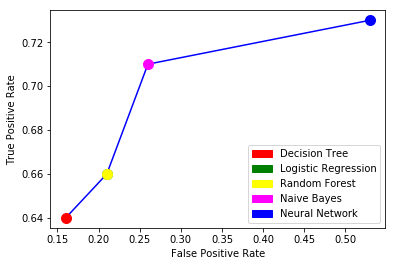

In [113]:
plot_roc_curve(confusion_matrix_list, models, 'False Positive Rate', 'True Positive Rate')